C:\Users\adwan\AppData\Local\Temp\ipykernel_14020\3764471312.py:156: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


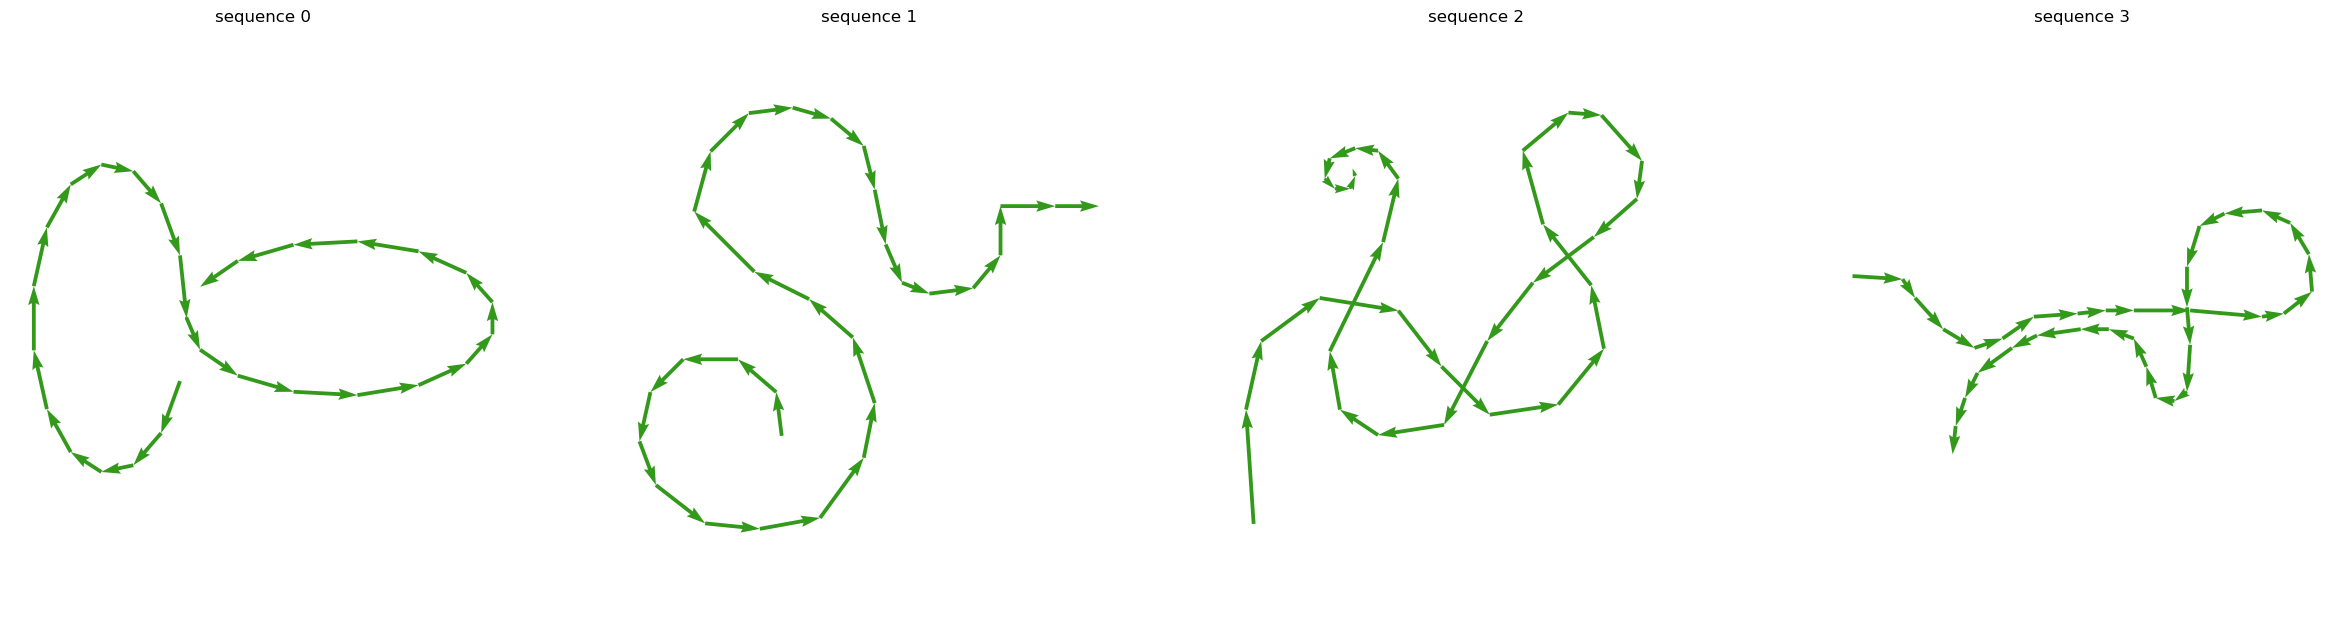

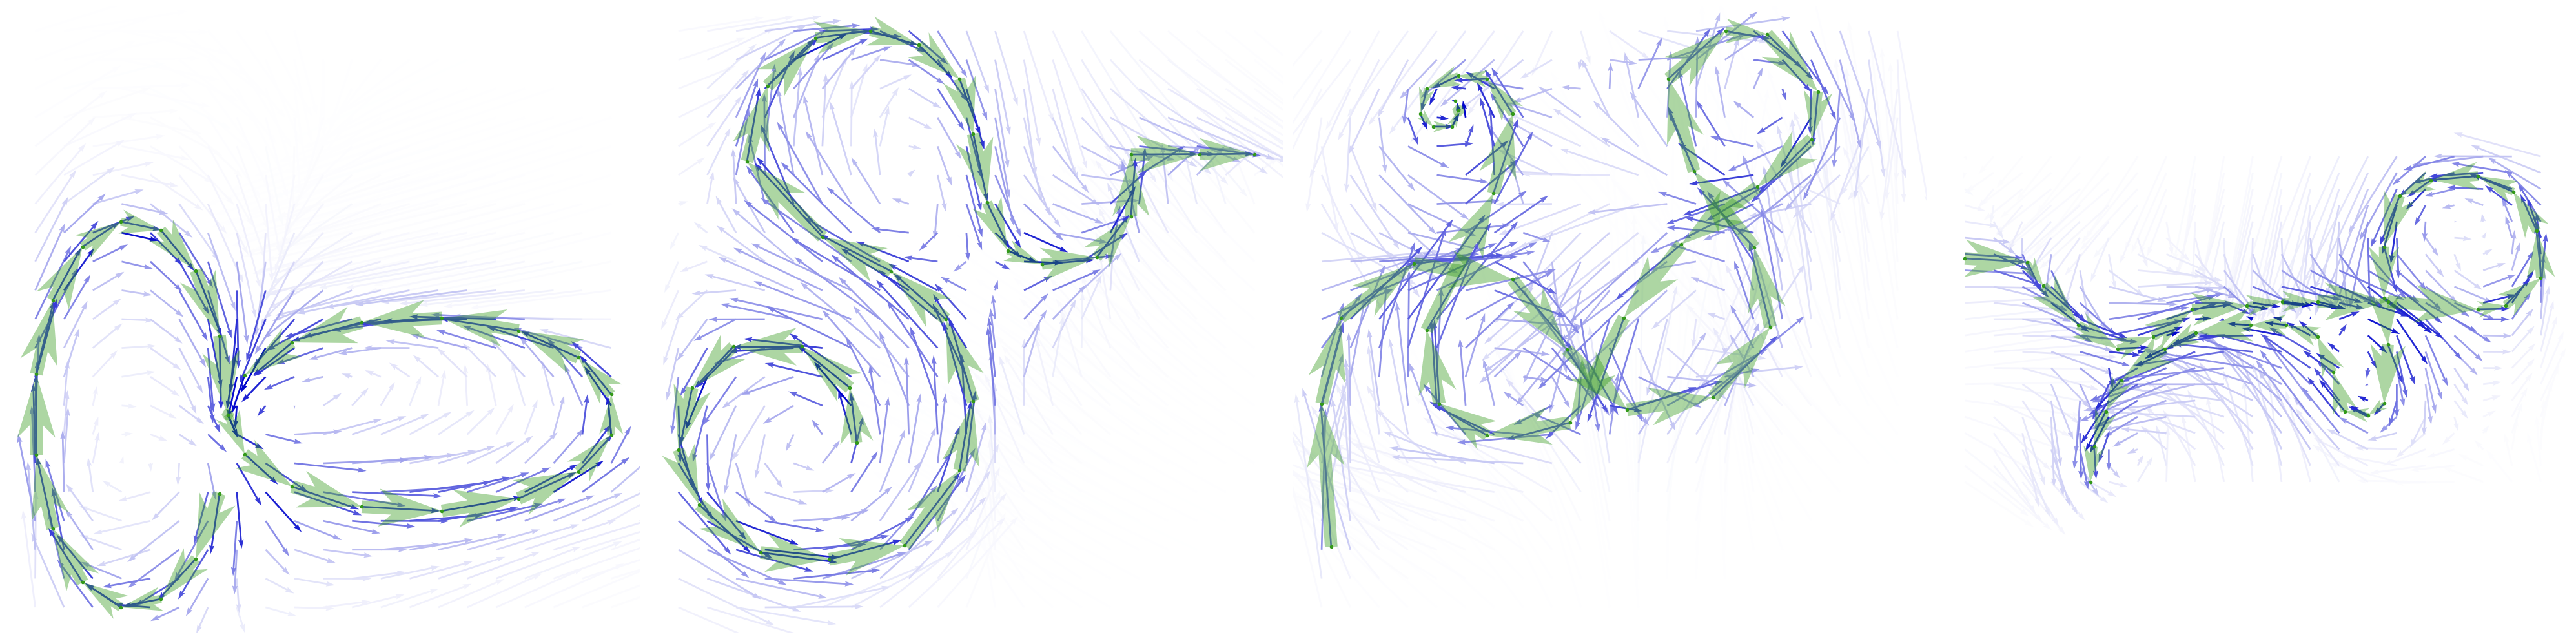

In [1]:
"""Bayes_linreg_2D_batch.py

# One-shot learning of trajectories, using (just) Bayesian linear regression.

We're taking one position $\mathbf{x} = (x_1, x_2)$, and predicting the next, $\mathbf{x}^\prime = (x^\prime_1, x\prime_2)$. But going directly from 2 to 2, linearly, will be very ineffective.

So we project up into a "hidden" space, via randomly initialised, and frozen, intut-to-hidden weights (and biases). We don't care about these at all, as they're not going to be learned. The hidden layer should be quite big, so that there are plenty of "hyperplanes" that (randomly) go near any given point $\mathbf{x}$, otherwise we won't be able to capture the obviously non-linear nature of a trajectory.
"""

"""# set up """

import numpy as np
import matplotlib.pyplot as plt
import numpy.random
np.random.seed(42)

"""# data """

sequences = []
mypathcolour, mypredcolour = np.array([.2,.6,.1]), np.array([0,.02,.8])

sequences = []  # list to hold various sequences

# washing machine, not much data
ts = np.linspace(1.0, 0.0, 16)
seqA = np.array([(np.cos(2*np.pi*ts)-1)/2., np.sin(2*np.pi*ts)]).T
seqB = np.array([(-np.cos(2*np.pi*ts)+1), -np.sin(-2*np.pi*ts)/2.0]).T
seq = np.concatenate((seqA,seqB),0)[1:-1,:]
seq = 2*(seq-np.min(seq))/(np.max(seq)-np.min(seq))-1 # scale to [-1,1]
sequences.append(seq)

# squiggles but no crossings
seq = 3.0*np.array([[0.01,-0.01],[0.00,0.07],[-0.07,0.13],[-0.17,0.13],[-0.23,0.07],[-0.25,-0.02],[-0.22,-0.10],
                [-0.13,-0.17],[-0.03,-0.18],[0.08,-0.16],[0.16,-0.05],[0.18,0.05],[0.14,0.17],[0.06,0.24],
                [-0.04,0.29],[-0.15,0.40],[-0.12,0.51],[-0.05,0.58],[0.03,0.59],[0.10,0.57],[0.16,0.52],
                [0.18,0.44],[0.20,0.34],[0.23,0.27],[0.28,0.25],[0.36,0.26],[0.41,0.32],[0.41,0.41],[0.51,0.41],[0.59,0.41]])
seq = 2*(seq-np.min(seq))/(np.max(seq)-np.min(seq))-1 # scale to [-1,1]
sequences.append(seq)

# cat with crossings
seq= np.array([[-0.87,-0.71],[-0.90,-0.26],[-0.84,0.01],[-0.61,0.18],[-0.30,0.13],[-0.13,-0.09],[0.06,-0.28],[0.33,-0.24],[0.51,-0.02],[0.46,0.23],[0.27,0.47],[0.19,0.76],[0.37,0.91],[0.50,0.90],[0.66,0.72],[0.64,0.57],[0.47,0.42],[0.23,0.24],[0.05,0.01],[-0.12,-0.32],[-0.38,-0.36],[-0.53,-0.26],[-0.57,-0.03],[-0.36,0.40],[-0.30,0.65],[-0.38,0.76],[-0.47,0.77],[-0.57,0.73],[-0.59,0.65],[-0.55,0.61],[-0.49,0.61],[-0.47,0.66],[-0.48,0.69]])
seq = 2*(seq-np.min(seq))/(np.max(seq)-np.min(seq))-1 # scale to [-1,1]
sequences.append(seq)

# true collision, plus contraflow
seq = 2*np.array([[-0.81,0.08],[-0.65,0.07],[-0.61,0.01],[-0.52,-0.09],[-0.42,-0.15],[-0.33,-0.12],[-0.23,-0.05],[-0.09,-0.04],[0.00,-0.03],[0.09,-0.03],[0.27,-0.03],[0.50,-0.05],[0.57,-0.04],[0.66,0.03],[0.65,0.15],[0.59,0.25],[0.50,0.29],[0.38,0.28],[0.30,0.24],[0.26,0.11],[0.26,-0.02],[0.27,-0.14],[0.26,-0.29],[0.22,-0.32],[0.16,-0.31],[0.13,-0.21],[0.09,-0.12],[0.01,-0.09],[-0.08,-0.09],[-0.22,-0.11],[-0.30,-0.15],[-0.41,-0.23],[-0.45,-0.31],[-0.48,-0.40],[-0.49,-0.49]])
seq = 2*(seq-np.min(seq))/(np.max(seq)-np.min(seq))-1 # scale to [-1,1]
sequences.append(seq)


# Show them all
f, axs = plt.subplots(1, len(sequences), sharex='all')#, sharey='all')
f.set_figwidth(30.0)
f.set_figheight(30.0/len(sequences))
for i in range(len(sequences)):
  seq = sequences[i]
  axs[i].quiver(seq[:-1,0], seq[:-1,1], seq[1:,0]-seq[:-1,0], seq[1:,1]-seq[:-1,1],
                color=mypathcolour, scale_units='xy', angles='xy', scale=1);
  axs[i].title.set_text('sequence {0}'.format(i));
  axs[i].axis('equal');
  axs[i].axis('off');


"""# model definition"""

def calc_input2hid(params, data):
  z = np.dot(data, params['wHid'].T) + params['bHid'].T # x is the seq projected into feature space
  z = z * (z>0)  # ReLU
  z[:,0] = np.ones(z[:,0].shape)  # the first "feature" is going to be bias (1)
  return z

def set_fixed_params(Nhid=100):
    Nins = 2
    params = {
        'wHid': numpy.random.randn(Nhid, Nins) / np.sqrt(Nins),  # fixed weights
        'bHid': numpy.random.randn(Nhid, 1),  # fixed biases to match
        'sigma2_prior': 5,   # prior variance
        'sigma2_noise': .01,  # observation noise variance np.power(0.1, 2)
        'W_map': np.zeros((Nhid,Nins)),
        'Cov_map': np.eye(Nhid)
    }
    return params


"""# algorithm"""

from numpy.linalg import inv

def batch_Bayesian_regression(trainSeq, testPoints, params):

    # non-essential, I just give things local names
    wHid = params['wHid']
    bHid = params['bHid']
    sigma2_prior = params['sigma2_prior']
    sigma2_noise = params['sigma2_noise']
    Nhid = len(bHid)

    # Project training data into the hidden space
    trainHid = calc_input2hid(params, trainSeq)

    X_train = trainHid[:-1]  # inputs: hidden representations of the current points
    Y_train = trainSeq[1:]   # outputs: the next points in the trajectory

    ## TODO for the assignment

    A = np.dot(X_train.T, X_train) + (sigma2_noise / sigma2_prior) * np.eye(X_train.shape[1])
    A_inv = inv(A)

    # Compute the posterior mean of the weights
    params['W_map'] = np.dot(A_inv, np.dot(X_train.T, Y_train))

    # Update the posterior covariance
    params['Cov_map'] = sigma2_noise * A_inv
    
    
    
    # End of TODO
    
    return params



"""# plotting"""

def do_plot(ax, trainSeq, testPoints, params):

    if len(testPoints) > 0:
        testHid = calc_input2hid(params, testPoints)
        predTest = np.dot(testHid, params['W_map'])
        diffTest = predTest - testPoints

        # Here is where we set the prediction "error bars", except I'm inverting those
        # to get prediction "precisions" instead, for purposes of display.
        testPrecisions = 1.0 / (params['sigma2_noise'] + np.diag(
            np.matmul(testHid, np.dot(params['Cov_map'], testHid.T))))
        
        testPrecisions /= np.max(np.abs(np.ravel(testPrecisions)))  
        # This is just for display niceness: resets the max "precision" to 1
        ord = np.argsort(testPrecisions)
        colours = np.ones(3) - np.outer(testPrecisions[ord], np.ones(3) - mypredcolour)
        if np.array_equal(trainSeq, testPoints):  colours = mypredcolour

        ax.quiver(testPoints[ord, 0], testPoints[ord, 1], 
                    diffTest[ord, 0], diffTest[ord, 1],
                    color=colours, scale_units='xy', angles='xy', scale=1.0)

    ax.plot(trainSeq[:, 0], trainSeq[:, 1], '.', color=mypathcolour)
    ax.quiver(trainSeq[:-1, 0], trainSeq[:-1, 1], 
                trainSeq[1:, 0] - trainSeq[:-1, 0],
                trainSeq[1:, 1] - trainSeq[:-1, 1], color=mypathcolour,
                scale_units='xy', angles='xy', scale=1, alpha=0.4, width=.02,
                headaxislength=4)

    ax.axis('equal')
    ax.axis('off')
    plt.tight_layout()

    return

##########################################################################

"""# main program """

f, axs = plt.subplots(1, len(sequences), sharex='all')
f.set_figwidth(10 * len(sequences))
f.set_figheight(10)

for i in range(len(sequences)):
    # Reinitialize parameters to the priors and so on, for each sequence
    params = set_fixed_params(Nhid=100)

    # Make a meshgrid for display purposes. Push it through the feature layer too.
    mx, my = np.max(np.abs(np.ravel(sequences[i][:, 0]))), np.max(np.abs(np.ravel(sequences[i][:, 1])))
    X, Y = np.meshgrid(np.linspace(-mx, mx, 21), np.linspace(-my, my, 21), indexing='ij')
    gridTestPoints = np.vstack([X.ravel(), Y.ravel()]).T
    testPts = np.concatenate((sequences[i], gridTestPoints), 0)

    # Perform Bayesian regression and plot the results
    params = batch_Bayesian_regression(sequences[i], testPts, params)
    do_plot(axs[i], sequences[i], testPts, params)
    
plt.savefig("trajectory-predictions")
